In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Download Dataset


In [ ]:


%cd /content/drive/MyDrive/3314 ML/COMP3314_A3
!git clone https://github.com/kanneroot/hku-comp3314-2024-1a-a3-image-classification-challenge.git
%cd hku-comp3314-2024-1a-a3-image-classification-challenge
!git checkout master

/content/drive/MyDrive/3314 ML/COMP3314_A3
fatal: destination path 'hku-comp3314-2024-1a-a3-image-classification-challenge' already exists and is not an empty directory.
/content/drive/MyDrive/3314 ML/COMP3314_A3/hku-comp3314-2024-1a-a3-image-classification-challenge
fatal: Unable to create '/content/drive/MyDrive/3314 ML/COMP3314_A3/hku-comp3314-2024-1a-a3-image-classification-challenge/.git/index.lock': File exists.

Another git process seems to be running in this repository, e.g.
an editor opened by 'git commit'. Please make sure all processes
are terminated then try again. If it still fails, a git process
may have crashed in this repository earlier:
remove the file manually to continue.


# Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import cv2
import os


# Load Dataset

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/3314 ML/COMP3314_A3/hku-comp3314-2024-1a-a3-image-classification-challenge/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/3314 ML/COMP3314_A3/hku-comp3314-2024-1a-a3-image-classification-challenge/test.csv')

# Process

In [5]:
from concurrent.futures import ThreadPoolExecutor

def load_and_preprocess_image(image_path):
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        return None
    # Resize image to a fixed size, e.g., 64x64
    img = cv2.resize(img, (64, 64))
    # Flatten the image
    img_flat = img.flatten()
    return img_flat

def load_images_threading(image_paths):
    X = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        results = executor.map(load_and_preprocess_image, image_paths)
    for result in results:
        if result is not None:
            X.append(result)
    return np.array(X)

train_ims_path = '/content/drive/MyDrive/3314 ML/COMP3314_A3/hku-comp3314-2024-1a-a3-image-classification-challenge/train_ims'

image_paths = [os.path.join(train_ims_path, name)for name in train_df['im_name']]

X_train = load_images_threading(image_paths)
y_train = train_df['label'].values


# Feature Extraction with PCA

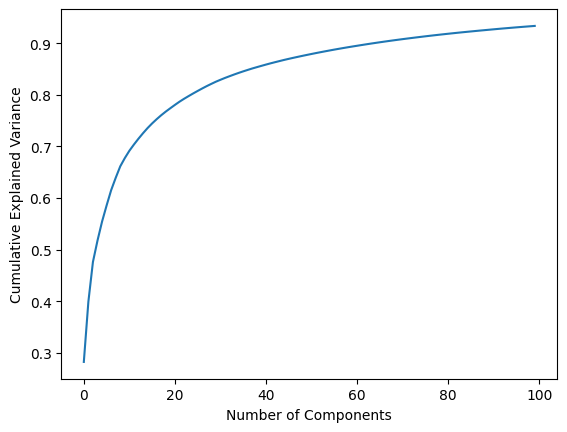

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=100)  # Adjust the number based on variance explained
X_train_pca = pca.fit_transform(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()



# Model Training with SVM

In [7]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_tr, y_tr)
print("Best Parameters:", grid.best_params_)
svm_model = grid.best_estimator_



ValueError: Found input variables with inconsistent numbers of samples: [8550, 50000]

# Model Evaluation

In [ ]:
y_pred = svm_model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:")
print(classification_report(y_val, y_pred))


conf_mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Prepare Test Data

In [ ]:
X_test = []
im_names = []

test_ims_path = '/content/drive/MyDrive/3314 ML/COMP3314_A3/hku-comp3314-2024-1a-a3-image-classification-challenge/test_ims'

for index, row in test_df.iterrows():
    image_path = os.path.join(test_ims_path, row['im_name'])
    img_flat = load_and_preprocess_image(image_path)
    X_test.append(img_flat)
    im_names.append(row['im_name'])

X_test = np.array(X_test)

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)


# Make Predictions on Test Data

In [ ]:
test_predictions = svm_model.predict(X_test_pca)


# Additional Tips

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_model, X_train_pca, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())


# Debug

In [12]:
print(X_train_pca.shape, y_train.shape)


(8550, 100) (50000,)


In [18]:
%cd /content/drive/MyDrive/3314 ML/COMP3314_A3/hku-comp3314-2024-1a-a3-image-classification-challenge/train_ims
!ls -1 | wc -l

/content/drive/MyDrive/3314 ML/COMP3314_A3/hku-comp3314-2024-1a-a3-image-classification-challenge/train_ims
8550
